# TP#2 : LSA et word2vec


## Approche du TP

Nous allons explorer les différents types de représentations distribuées vu au second cours, en commençant par un exemple simple d'application de la LSA. On l'appliquera ensuite à d'autres données.

Dans un second temps, on chargera un modèle word2vec pré-entraîné et on pourra le manipuler.

# Première partie : Latent Semantic Analysis

## Reprise de l'exemple du cours sur les titres de livres

Pendant le second cours, on avait vu sur un dataset très simple comment on pouvait utiliser la LSA pour projeter à la fois des mots et des documents dans le même espace.

On reprend ici les mêmes données pour voir en détails l'utilisation de la LSA.

In [98]:
titles = [ 
    "The Neatest Little Guide to Stock Market Investing", 
    "Investing For Dummies, 4th Edition", 
    "The Little Book of Common Sense Investing: The Only Way to Guarantee Your Fair Share of Stock Market Returns", 
    "The Little Book of Value Investing", 
    "Value Investing: From Graham to Buffett and Beyond", 
    "Rich Dad's Guide to Investing: What the Rich Invest in, That the Poor and the Middle Class Do Not!", 
    "Investing in Real Estate, 5th Edition", 
    "Stock Investing For Dummies", 
    "Rich Dad's Advisors: The ABC's of Real Estate Investing: The Secrets of Finding Hidden Profits Most Investors Miss" 
]

stopwords = ['and','edition','for','in','little','of','the','to'] 
ignorechars = [",", ":", "'", "!"]

Le traitement des documents va inclure les étapes suivantes :
* tokenisation sur les espaces
* suppression de toute la ponctuation
* suppression des tokens qui ne sont pas exclusivement constitués de lettres
* suppression des stopwords avec la liste fournie ci-dessus
* vectorisation
* (optionnel) suppression des hapaxes
* (optionnel) transformation TF.IDF (en utilisant la classe [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) de `sklearn`)

A vous de vous inspirer du premier TP et d'implémenter :
* une fonction `parse()` qui va prendre en argument un document, et renvoyer un dictionnaire `{mot: compte}` en ayant effectué les opérations de nettoyage nécessaires
* une fonction `vectorize()` qui va prendre en argument une liste de dictionnaire `{mot: compte}` et renvoyer la matrice correspondante, ainsi que le nom des colonnes

In [99]:
from collections import Counter
%config Completer.use_jedi = False

def parse(document):

    # make lower case for all the texts
    data = document.lower()

    # ponctuation
    # actually on ponctuation part, we need to consider more things like dot or question mark
    # but on this example, there's no that case so we will ignore the details
    for chars in ignorechars:
        data = data.replace(chars,"")
    
    # tokenization
    data_tokens = data.split()

    # normalisation 
    # tokens non alphabétiques + stopwords
    tokens_clean = [token for token in data_tokens if token.isalpha() and token not in stopwords]

    return Counter(tokens_clean)

In [100]:
from sklearn.feature_extraction import DictVectorizer

In [101]:
# vectorization
def vectorize(lists):
    vectorizer = DictVectorizer()

    return vectorizer.fit_transform(lists), vectorizer.get_feature_names()

In [102]:
letter_lists = [parse(t) for t in titles]

In [103]:
# result
X, feature_names = vectorize(letter_lists)

In [104]:
X.shape

(9, 42)

In [105]:
from sklearn.preprocessing import binarize

# delete hapaxes (rare words)
# axis = 0 means per word(column)
# will filter the words mentioned at least more than one time
# .A is for numpy ndarray
# .ravel is for vectorizing
column_filter = (binarize(X).sum(axis=0) > 1).A.ravel()

X = X[:, column_filter]

In [106]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF.IDF transformation
X = TfidfTransformer().fit_transform(X)

In [107]:
# filtered feature namesand matrix after delete hapaxes
filtered_feature_names = [feature_name for index,feature_name in enumerate(feature_names) if column_filter[index]]

Vous devriez avoir obtenu une matrice de dimensions (9 x 11).

Nous allons utiliser dans un premier temps l'implémentation de `scipy` pour le calcul de la SVD.

On récupère ainsi les trois matrice $U$, $\Sigma$ et $V$ ($V$ étant sous sa forme transposée $V^\top$) comme vu en cours.

![](./SVD_decomposition.png)

In [108]:
from scipy.linalg import svd

# U x Σ x Vt = M
U, Σ, Vt = svd(X.toarray())

On peut interprêter U comme étant la matrice qui permet de projeter les documents et $V^\top$ comme celle qui permet de projeter les mots.

On va donc essayer de visualiser les titres et les mots du vocabulaire dans un espace 2 x 2 en utilisant uniquement deux dimensions.

Comme vu en cours, la première dimension n'est pas très intéressante car elle encode la moyenne des documents, on va donc utiliser les deux suivantes (indices de 1 à 3).

In [109]:
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, "Visualisation dans l'espace projeté")

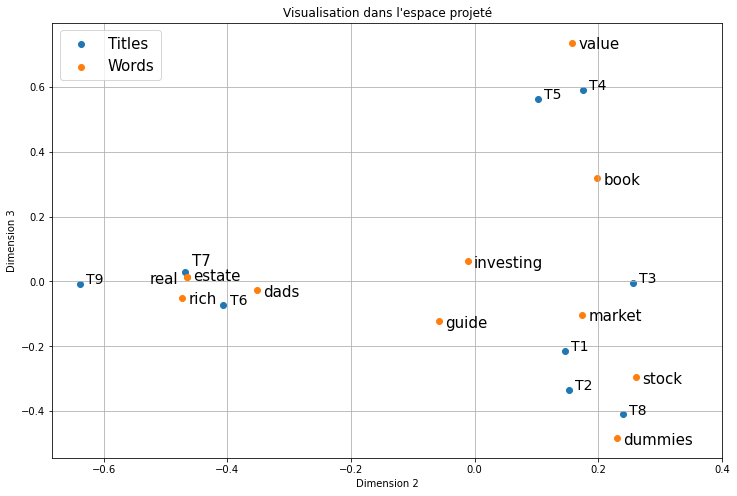

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

# will use 2nd and 3rd columns of matrix U
x_doc, y_doc = U[:,1:3].T
ax.scatter(x_doc, y_doc, label="Titles")

for x_, y_, s in zip(x_doc, y_doc, ["T%d" % (i + 1) for i in range(len(x_doc))]):
    # Ici, on gère un cas spécial pour que "T7" et "estate"ne se superposent pas avec un léger décalage vers le haut
    if s == "T7":
        ax.text(x_ + 0.01, y_ + 0.02, s, fontsize=15)
    else:
        ax.text(x_ + 0.01, y_, s, fontsize=14)

x_term, y_term = Vt[1:3,]
ax.scatter(x_term, y_term, label="Words")
for x_, y_, s in zip(x_term, y_term, filtered_feature_names):
    if s == "real":
        ax.text(x_ - 0.06, y_ - 0.02, s, fontsize=15)
    elif s == "estate":
        ax.text(x_ + 0.01, y_ - 0.01, s, fontsize=15)
    else:
        ax.text(x_ + 0.01, y_ - 0.02, s, fontsize=15)

ax.grid()
ax.set_xlim(right=0.4)
ax.legend(fontsize=15, loc=2)
ax.set_xlabel("Dimension 2")
ax.set_ylabel("Dimension 3")
ax.set_title("Visualisation dans l'espace projeté")

On retrouve à peu près le graphe vu en cours, à une symétrie centrale près, c'est-à-dire que nos axes verticaux et horizontaux sont inversés.

C'est la conséquence de l'algorithme utilisé, qui peut renvoyer les résultats avec un signe différent selon un état interne d'initialisation.

La matrice $V$ (soit $(V^\top)^\top$) contient le codage des concepts, qu'on peut afficher comme suit :

In [111]:
import numpy as np

# Pour construire une telle expression, on procède par étapes :
# 1. on va d'abord assembler les coefficients et les mots avec `zip` ; les coefficients pour le k-ième concept sont stockés dans la k-ième ligne de la matrice Vt (encore une fois, V est la matrice de passage mots -> espace projeté et Vt est sa transposée, cela a donc du sens)
# 2. les coefficients les plus importants auront une plus grande valeur absolue, on va donc trier les paires (coeff, mot) avec `sorted` (voir la documentation [ici](https://docs.python.org/3.6/howto/sorting.html#sortinghowto) pour quelques exemples d'utilisation)
# 3. on ne récupère que les cinq mots les plus importants
# 4. on itère ensuite sur ces paires triées pour les transformer en chaîne de caractères incluant le signe du coefficient, sa valeur absolue et le mot
# 5. on assemble la liste de chaînes de caractères obtenue avec un espace entre chaque et on affiche

index_concept = 2
print(" ".join(["%s %.2f * %s" % ("+" if coeff >= 0 else "-", np.fabs(coeff), mot)\
                for coeff, mot in sorted(zip(Vt.T[index_concept], filtered_feature_names),
                                         key=lambda x: np.fabs(x[0]),
                                         reverse=True)[:5]]) + " + ...")

- 0.61 * estate - 0.48 * dummies + 0.37 * book - 0.31 * stock + 0.23 * dads + ...


Essayez d'afficher la formule d'autres concepts. Que dire de la facilité de compréhension de cette représentation ?

In [112]:
# show the the coefficient matrix 
# as we can see, it's not easy to recongnize the important coefficient value and to match with token word
Vt.T[index_concept]

array([ 0.36607883,  0.2302428 , -0.48349996, -0.61173663,  0.16245458,
       -0.13336232, -0.18184581, -0.02427016, -0.1749236 , -0.30735572,
       -0.04561679])

In [113]:
import pandas as pd

# make a dataframe by using coefficient values and word
tmp_df = pd.DataFrame(columns=['coeff', 'word','abs coeff'])
for coeff, mot in sorted(zip(Vt.T[index_concept], filtered_feature_names)):
    tmp_df = tmp_df.append({'coeff': coeff, 'word': mot, 'abs coeff':abs(coeff)}, ignore_index=True)

In [114]:
# in this way, it's way better to recongnize than matrix
# however, to check at a glance, the first equation concept looks best
tmp_df.sort_values(by='abs coeff',ascending=False)

,coeff,word,abs coeff
0,-0.611737,estate,0.611737
1,-0.483500,dummies,0.483500
10,0.366079,book,0.366079
2,-0.307356,stock,0.307356
9,0.230243,dads,0.230243
3,-0.181846,market,0.181846
4,-0.174924,rich,0.174924
8,0.162455,guide,0.162455
5,-0.133362,investing,0.133362
6,-0.045617,value,0.045617


## Application avec le corpus AG news et scikit-learn

Il s'agit d'un corpus d'articles de presse constitué dans le cadre académique par Antonio Gulli, de l'Université de Pise. Il contient plus d'un million d'articles provenant de 2000 sources (plus de détails [ici](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)).

Nous allons utiliser une version simplifiée d'un peu moins de 130 000 articles, répartis sur quatre classes, utilisée dans un article de [Zhang, Zhao & LeCun (2015)](https://arxiv.org/abs/1509.01626) pour une tâche de classification utilisant des réseaux de neurones convolutionnels.

Il vous faudra donc télécharger les données sur [ce dépôt github](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv) pour pouvoir regarder le contenu des fichiers avec `head` et compter le nombre d'exemples dans les ensembles d'apprentissage et de test.

In [115]:
!head train.csv

"3","Wall St. Bears Claw Back Into the Black (Reuters)","Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"3","Carlyle Looks Toward Commercial Aerospace (Reuters)","Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
"3","Oil and Economy Cloud Stocks' Outlook (Reuters)","Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums."
"3","Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)","Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
"3","Oil prices soar to all-time record, posing new menace to US e

In [116]:
!head test.csv

"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning wil

Les fichiers sont au format CSV avec trois colonnes correspondant à la classe, au titre et au contenu de l'article.

On veut récupérer les données de la manière suivante :
1. parser le fichier `test.csv` et extraire :
  * dans une liste `documents` le contenu textuel concaténé de chaque article (titre + contenu)
  * dans une liste `y` la classe de chaque article (encodé par un nombre)
2. récupérer le label de chaque classe dans le fichier `classes.txt` et modifier `y` pour avoir une liste de labels
3. vectoriser les documents dans une matrice `X`
4. modifier `X` pour ne garder que les features qui apparaîssent au moins 3 fois dans le corpus

### Parsing des fichiers

In [117]:
# make dataframe first
train = pd.read_csv("train.csv", names=["label","title","content"]) 
train

,label,title,content
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [118]:
# get class names
classes = open("classes.txt", "r").read().split('\n')
classes = list(filter(lambda x: len(x)>0,classes))
classes

['World', 'Sports', 'Business', 'Sci/Tech']

In [119]:
# change label from int to string (name of classes.txt)
train["label"] = train["label"].apply(lambda x: classes[x-1])

In [120]:
train

,label,title,content
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [121]:
# to use the same way of example we did, data has to be changed to list format not dataframe

# extract label values from train and will use a class
y_train = train["label"].tolist()

# extract title and content values and will use the text for vectorization
# combine them as a sentence
train_data = (train["title"]+" "+train["content"]).tolist()

In [122]:
train_data

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
 'Oil prices soar to all-time record, posing new menace to US economy (A

In [123]:
# on text we can fine \\ charactors what we don't want
# I can add this part on parse function to replace with space
# but for now I will replace \\ as space
train_data = [data.replace("\\", " ") for data in train_data]

### Vectorisation

On pourra utiliser les stopwords anglais de NLTK. Pour cela :
* importer le corpus des stopwords en faisant `from nltk.corpus import stopwords`
* si NLTK n'est pas installé, faites-le avec `pip` ; il vous faudra ensuite exécuter, dans un interpréteur python utilisant le même `virtualenv`, la commande `nltk.download()`, et télécharger le corpus `stopwords`.
* récupérer dans une liste les stopwords anglais en faisant `stopwords = stopwords.words("english")`

In [124]:
# !pip install nltk

In [125]:
from nltk.corpus import stopwords

# get the stopwords by NLTK and will use instead of stopwords of example
stopwords = stopwords.words("english")

In [126]:
train_lists = [parse(data) for data in train_data]

In [127]:
# vectorization
train_matrix, train_feature_names = vectorize(train_lists)

In [128]:
train_matrix.shape

(120000, 59245)

### Utilisation de scikit-learn

On va utiliser la classe [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) de scikit-learn, qui fait le calcul de SVD de manière plus rapide.

from sklearn.decomposition import TruncatedSVDIl suffit de d'initialiser une instance de la classe et d'appeler la méthode `.fit_transform()` avec notre matrice X en argument.

In [129]:
from sklearn.decomposition import TruncatedSVD

svd_transformer = TruncatedSVD(n_components=200)
train_matrix_k = svd_transformer.fit_transform(train_matrix)

Comparer la dimension des matrices X et Xk et commenter.

In [130]:
train_matrix.shape

(120000, 59245)

In [131]:
train_matrix_k.shape

(120000, 200)

`TruncatedSVD` ne renvoit donc qu'une seule matrice $X_k$ au lieu de trois matrices $U_k$, $\Sigma_k$ et $V_k^\top$. Ce n'est pas grave car ce qui nous intéresse dans un pipeline de traitement est bien la matrice $X_k$.

De plus, on peut passer d'une formulation à l'autre puisque :
* $X_k = U_k \Sigma_k$
* les valeurs de la diagonale de $\Sigma_k$ sont stockées dans le membre `singular_values_` de `TruncatedSVD`
* la matrice $V_k^\top$ est stockée dans le membre `components_` de `TruncatedSVD`

Cette différence d'implémentation et d'utilisation est expliquée en détails dans la [documentation de scikit-learn](http://scikit-learn.org/stable/modules/decomposition.html#lsa).

In [132]:
svd_transformer.singular_values_

array([218.0793276 , 158.99968685, 145.28913315, 133.00427652,
       126.45637604, 119.93858087, 113.56370596, 106.60435646,
       100.47682822, 100.01232709,  97.58227734,  97.03097736,
        95.22333708,  94.47945682,  93.28520272,  91.81996907,
        89.81324666,  88.9052566 ,  86.72189044,  85.97937035,
        85.52692698,  84.88648424,  83.92832212,  83.39678148,
        82.93552775,  81.57552245,  81.11983133,  80.40218688,
        80.11446795,  79.47627031,  79.37836518,  78.59738988,
        78.01229298,  77.85436323,  77.66908857,  77.55122043,
        76.89007249,  76.4228545 ,  76.00041321,  75.8040907 ,
        74.81249081,  74.66342717,  74.4527842 ,  74.04383107,
        73.64524381,  73.46501358,  72.83129493,  72.41118917,
        72.2921712 ,  71.93940583,  71.81216017,  71.10131821,
        70.9391992 ,  70.84011935,  70.53096615,  70.35139426,
        69.93999802,  69.78243341,  69.27086653,  69.21460675,
        69.01900921,  68.70456244,  68.50383137,  68.30

### Classification

On peut maintenant brancher notre pipeline à un classifieur, comme dans le premier TP.

Reprendre la fonction `classify_and_evaluate()` et l'appliquer à `X` et `y` ci-dessous.

In [133]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

def classify_and_evaluate(X, y):
    cls = MultinomialNB()
    predictions = cross_val_predict(cls, X, y)
    print("Nombre d'erreurs :", len([(truth, prediction)\
                                     for truth, prediction in zip(y, predictions)\
                                     if truth != prediction]), end="\n\n")
    print(classification_report(y, predictions))

In [134]:
classify_and_evaluate(train_matrix, y_train)

Nombre d'erreurs : 12694

              precision    recall  f1-score   support

    Business       0.86      0.85      0.86     30000
    Sci/Tech       0.86      0.87      0.86     30000
      Sports       0.95      0.97      0.96     30000
       World       0.91      0.88      0.90     30000

    accuracy                           0.89    120000
   macro avg       0.89      0.89      0.89    120000
weighted avg       0.89      0.89      0.89    120000



### Visualisation des mots les plus importants

On va visualiser en deux dimensions les 50 mots les plus importants, ainsi que 50 articles tirés au hasard pour les classes `"Sports"` et `"Sci/Tech"`.

Pour cela, exécuter les cellules ci-dessous.

In [135]:
# Filtrage des mots peu présents, récupération de ces mots dans une liste

# On utilise le même type de filtrage que vu plus pour supprimer plus de colonnes (donc de mots).
X, feature_names = vectorize(map(parse, train_data))
keeping = (X.sum(axis=0) > 3).A.ravel()
X = X[:,keeping]
# On peut utiliser le vecteur de booléens `keeping` pour construire la liste des mots gardés.
# C'est facile puisque `keeping` et `feature_names` sont alignés, c'est-à-dire que ce sont des listes
# de même taille, stockant des informations sur les mêmes choses dans le même ordre, par construction.
kept_features = [f_name for f_name, keep in zip(feature_names, keeping) if keep]

In [136]:
# Normalisation TF.IDF
X = TfidfTransformer(norm=False).fit_transform(X)

In [137]:
# On filtre sur les classes qui nous intéressent
kept_rows = [i for i, elem in enumerate(y_train) if elem in ["Sci/Tech", "Sports"]]
y = [y_train[i] for i in kept_rows]
X = X[kept_rows]

In [138]:
# Calcul des mots les plus représentés
best_words_idx = np.argsort(X.sum(axis=0).A.ravel())[-50:]
best_words = [kept_features[i] for i in best_words_idx]

In [139]:
# Transformation LSA
svd_transformer = TruncatedSVD(n_components=200)
Xk = svd_transformer.fit_transform(X)

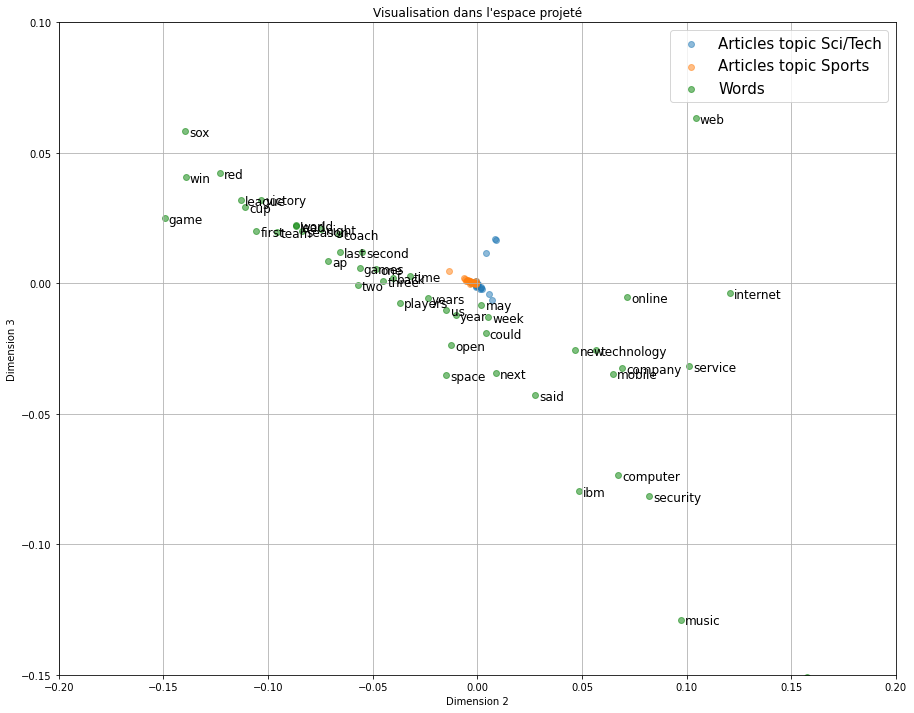

In [140]:
# Visualisation
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)

# On sélectionne 50 articles au hasard
import random
random_lines = random.sample(range(X.shape[0]), 50)

x_doc, y_doc = (Xk[:,1:3] * (1. / svd_transformer.singular_values_[1:3]))[random_lines].T
labels_selected_articles = [y[i] for i in random_lines]

for topic in set(labels_selected_articles):
    x_doc_ = [x_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
    y_doc_ = [y_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
    ax.scatter(x_doc_, y_doc_, alpha=0.5, label="Articles topic " + topic)

ax.set_ylim(top=0.1, bottom=-0.15)
ax.set_xlim(right=0.2, left=-0.2)

x_term, y_term = svd_transformer.components_[1:3,best_words_idx]
ax.scatter(x_term, y_term, c="g", alpha=0.5, label="Words")
for x_, y_, s in zip(x_term, y_term, best_words):
    if x_ >= ax.get_xlim()[0] and x_ <= ax.get_xlim()[1] and y_ >= ax.get_ylim()[0] and y_ <= ax.get_ylim()[1]:
        ax.text(x_ + 0.002, y_ - 0.002, s, fontsize=12)

ax.grid()
ax.legend(fontsize=15, loc=0)
ax.set_xlabel("Dimension 2")
ax.set_ylabel("Dimension 3")
ax.set_title("Visualisation dans l'espace projeté");

In [141]:
# because we project datas, the classification is not perfectly clear
# but if we focus on (0,0)
# the data of Sci/Tech are distributed right side
# the data of Sports are distributed left side

Commenter la visualisation.

Text(0.5, 1.0, "Visualisation dans l'espace projeté")

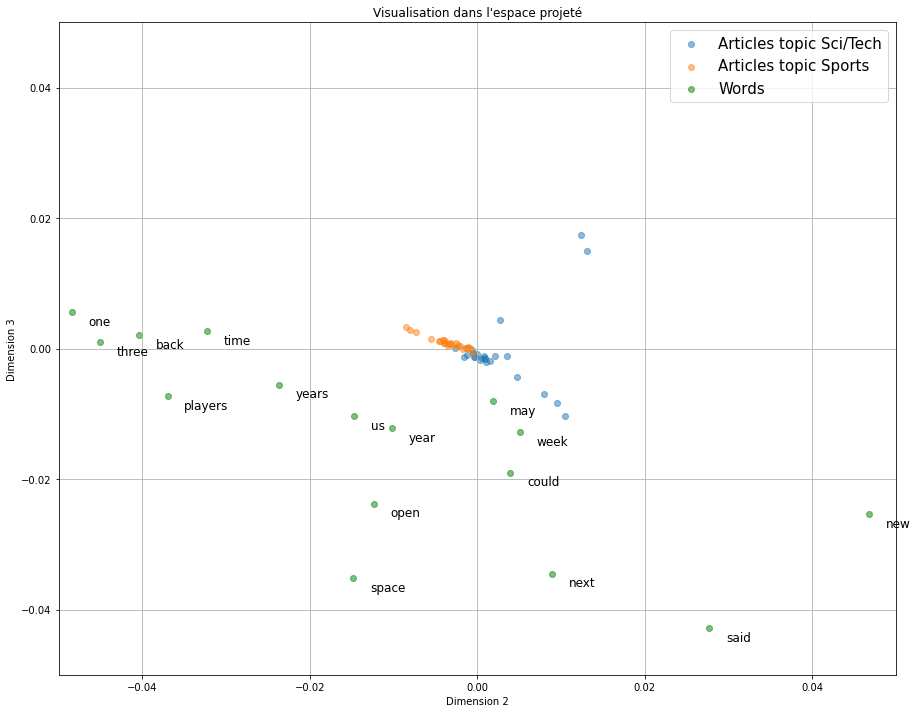

In [142]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)

# On sélectionne 50 articles au hasard
import random
random_lines = random.sample(range(X.shape[0]), 50)

x_doc, y_doc = (Xk[:,1:3] * (1. / svd_transformer.singular_values_[1:3]))[random_lines].T
labels_selected_articles = [y[i] for i in random_lines]

for topic in set(labels_selected_articles):
    x_doc_ = [x_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
    y_doc_ = [y_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
    ax.scatter(x_doc_, y_doc_, alpha=0.5, label="Articles topic " + topic)

ax.set_ylim(top=0.05, bottom=-0.05)
ax.set_xlim(right=0.05, left=-0.05)

x_term, y_term = svd_transformer.components_[1:3,best_words_idx]
ax.scatter(x_term, y_term, c="g", alpha=0.5, label="Words")
for x_, y_, s in zip(x_term, y_term, best_words):
    if x_ >= ax.get_xlim()[0] and x_ <= ax.get_xlim()[1] and y_ >= ax.get_ylim()[0] and y_ <= ax.get_ylim()[1]:
        ax.text(x_ + 0.002, y_ - 0.002, s, fontsize=12)

ax.grid()
ax.legend(fontsize=15, loc=0)
ax.set_xlabel("Dimension 2")
ax.set_ylabel("Dimension 3")
ax.set_title("Visualisation dans l'espace projeté")

In [143]:
# to be clear, I zoomed in the graph a bit
# as we can see, data can be separately classified by two classes
# because on the minus x axis, the border of two classes is not clear so
# it should be reinforced

# Deuxième partie : word2vec

On va utiliser un modèle pré-entraîné sur un dump de Wikipedia :
1. Commencer par télécharger les données de [ce lien](https://ibm.ent.box.com/s/77etivy69jmga0x0u6vs2n47ul8baks4).
2. Décompresser le fichier (`tar -xvfz /chemin/vers/votre/dossier/apnews_sg.tgz`)
3. Installer gensim (`pip3 install imutils --user`)
4. Charger le modèle.

In [144]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec.load("word2vec.bin")

On obtient une représentation dense de chaque mot.

In [145]:
model["man"]

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/4042434277.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model["man"]


array([ 4.27164972e-01,  5.73221892e-02,  6.15567043e-02,  9.54020619e-02,
        1.82786472e-02, -1.46983370e-01,  7.13451132e-02,  6.06862940e-02,
       -8.39615762e-02, -1.53227329e-01,  4.43859462e-04, -2.30238095e-01,
       -1.63750932e-01, -7.88985044e-02, -2.19980270e-01, -1.10849805e-01,
       -3.16224456e-01,  4.73360568e-02, -1.36688143e-01, -8.47528279e-02,
        4.17414382e-02, -2.37944260e-01, -8.70545283e-02, -1.48416489e-01,
       -1.77778006e-01, -6.55186623e-02, -2.81852245e-01, -2.74993867e-01,
       -8.86562616e-02,  9.41087212e-03,  6.84729740e-02, -1.02155343e-01,
       -4.34809029e-02,  1.09360971e-01,  2.75213152e-01,  1.47406206e-01,
        7.28204325e-02,  3.23610157e-02,  4.89586502e-01,  1.12016559e-01,
       -1.97800457e-01,  4.54594083e-02,  5.05269766e-02,  1.43815288e-02,
        2.31974587e-01,  4.53264602e-02, -1.64787903e-01,  1.11527778e-01,
        1.40989259e-01, -1.53619364e-01,  1.47233874e-01, -1.28524601e-01,
        2.60341875e-02,  

Examiner cette représentation pour voir déterminer la dimension de l'espace.

In [146]:
model["man"].shape

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/4268334186.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model["man"].shape


(300,)

On peut maintenant reproduire des exemples "d'algèbre sur les mots" : il faut indiquer les mots positifs et négatifs.

Essayez quelques exemples. Les résultats sont-ils les mêmes que ceux vus en cours ? Si non, pourquoi ?

In [147]:
#the expected result is mother and the value of right answer has the second highest value.
model.most_similar(positive=['girl', 'father'], negative=['boy'])

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/873844084.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['girl', 'father'], negative=['boy'])


[('daughter', 0.8421739935874939),
 ('mother', 0.8219131827354431),
 ('son', 0.8104175925254822),
 ('husband', 0.7870069742202759),
 ('wife', 0.749029278755188),
 ('grandmother', 0.7245616316795349),
 ('her', 0.7234212160110474),
 ('brother', 0.7050185799598694),
 ('sister', 0.701641857624054),
 ('aunt', 0.6941375732421875)]

In [148]:
# the expected result is queen and the value of right answer has the second highest value.
# wordvec can be easily understood if we think about vectors
# woman + (king-man) = queen
# king-man = royal
# woman+royal = res
# so the answer is "queen" that adds the value got between king and man to woman
model.most_similar(positive=['woman', 'king'], negative=['man'])

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/2984255688.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['woman', 'king'], negative=['man'])


[('luther', 0.5677588582038879),
 ('queen', 0.4844968914985657),
 ('martin', 0.44604235887527466),
 ('princess', 0.4392106235027313),
 ('bernice', 0.43639644980430603),
 ('coretta', 0.42410361766815186),
 ('414-403-5314', 0.4220905303955078),
 ('viii', 0.41455304622650146),
 ('http://www.twitter.com/caitlinrking', 0.4006994962692261),
 ('vi', 0.3979029059410095)]

In [149]:
# in this case the expected answer is queens that is plurality of queen
# queen + (kings-king) = queens
# however in this case, the right answer coeff value is not that high compare with the others and similar...
model.most_similar(positive=['queen', 'kings'], negative=['king'])

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/3646266518.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['queen', 'kings'], negative=['king'])


[('princesses', 0.3605149984359741),
 ('royals', 0.358207106590271),
 ('angels', 0.35462686419487),
 ('princess', 0.3503638207912445),
 ('rca/rmg', 0.34878426790237427),
 ('queens', 0.3408749997615814),
 ('bee', 0.33421576023101807),
 ('tuya', 0.3309422731399536),
 ('bon', 0.33064335584640503),
 ('royal', 0.32910266518592834)]

In [150]:
# for now we have not that great result about the example we saw in class
# to improve the accuracy of model, we should train the model as a supervised learning

## Classification du corpus AG News

Il faut repartir de la matrice simple de TF, et remplacer chaque mot par le vecteur correspondant ; le document est donc la moyenne des mots, chaque mot étant pondéré par sa fréquence d'apparition.

Première étape, on reconstruit la matrice de fréquences.

In [151]:
# we make new matrix and y value list
X, feature_names = vectorize(map(parse, train_data))
y = train["label"].tolist()
# transformation of TF.IDF
X = TfidfTransformer().fit_transform(X)
# delete the word mentioned less than 3
keeping = (X.sum(axis=0) > 3).A.ravel()
X = X[:,keeping]
kept_features = [f_name for f_name, keep in zip(feature_names, keeping) if keep]

On ne garde que les classes `"Sports"` et `"Sci/Tech"`.

In [152]:
kept_rows = [i for i, elem in enumerate(y) if elem in ["Sci/Tech", "Sports"]]
y_binary = [y[i] for i in kept_rows]
X_binary = X[kept_rows]

Et voilà l'étape de construction de la matrice de documents.

Examiner le code en essayant de comprendre chaque ligne et en expliquant en commentaires les grandes étapes.

In [153]:
# define the final list
embedded_docs = []
# we will repeat the procedure per line
for row in X_binary:
    # because we defined X_binary like "X_binary = X[kept_rows]"
    # the row that has class of Sci/Tech or Sports will has nonzero value
    # or will have zero value
    # so at this part, we filter them
    words_idx = row.nonzero()[1]
    # if it's filtered right before, we will fill blank with 0 with numpy function
    if not words_idx.shape[0]:
        embedded_docs.append(np.zeros(300))
        continue
    # TF.IDF values
    counts = row[0,words_idx].A.ravel()
    # the words what their value is not zero
    words = [kept_features[i] for i in words_idx]
    
    # the words consist line(row) will be saved on this list
    embedded_words = []
    for count, word in zip(counts, words):
        try:
            # TF.IDF(t, d) = TF(t, d) x IDF(t)
            embedded_words.append(model[word] * count)
        except KeyError:
            # if there's no the word, fill with 0
            embedded_words.append(np.zeros(300))
    #doc = np.array(embedded_words).sum(axis=0)
    # get the average of embedded_words and add on embedded_docs
    embedded_docs.append(np.array(embedded_words).mean(axis=0))
# make the format as numpt array
embedded_docs = np.array(embedded_docs)

/var/folders/ng/5wp3n5rj2j1_j1cdnlxjw88m0000gn/T/ipykernel_56545/4282807999.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedded_words.append(model[word] * count)


Quelle est la dimension de `embedded_docs` ?

In [154]:
embedded_docs.shape

(60000, 300)

Utiliser la fonction `classify_and_evaluate()` sur la matrice de TF et sur la matrice projetée.

Commenter.

In [155]:
classify_and_evaluate(embedded_docs + np.fabs(embedded_docs.min()), y_binary)

Nombre d'erreurs : 2291

              precision    recall  f1-score   support

    Sci/Tech       0.99      0.94      0.96     30000
      Sports       0.94      0.99      0.96     30000

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



In [156]:
classify_and_evaluate(X_binary + np.fabs(X_binary.min()), y_binary)

Nombre d'erreurs : 839

              precision    recall  f1-score   support

    Sci/Tech       0.99      0.98      0.99     30000
      Sports       0.98      0.99      0.99     30000

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [157]:
# with linear svc, it works well
from sklearn.svm import LinearSVC

def classify_and_evaluate(X, y):
    cls = LinearSVC()
    predictions = cross_val_predict(cls, X, y)
    print("Nombre d'erreurs :", len([(truth, prediction)\
                                     for truth, prediction in zip(y, predictions)\
                                     if truth != prediction]), end="\n\n")
    print(classification_report(y, predictions))

In [158]:
classify_and_evaluate(embedded_docs + np.fabs(embedded_docs.min()), y_binary)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

Nombre d'erreurs : 852

              precision    recall  f1-score   support

    Sci/Tech       0.99      0.98      0.99     30000
      Sports       0.98      0.99      0.99     30000

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [97]:
classify_and_evaluate(embedded_docs, y_binary)

Nombre d'erreurs : 824

              precision    recall  f1-score   support

    Sci/Tech       0.99      0.99      0.99     30000
      Sports       0.99      0.99      0.99     30000

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [ ]:
# As we check, the accuracies are over 95 and it looks successful